# Milestone Project 2 - Skim Lit

The purpose of this project is to take medical abstracts from medical research papers, and break them down into easily readable and shortened summaries of each abstract. This is based off the PubMed paper that performs the same experiment (see link below).

* https://arxiv.org/abs/1710.06071

This notebook will ru

## Environment Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

True

In [2]:
if on_colab:
  # Setting up the notebook with a GPU
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .
  !rm -rf ./notebooks

/bin/bash: line 1: nvidia-smi: command not found
  Cloning https://github.com/bkubick/py-learning-toolbox.git to /tmp/pip-install-_4v_6vev/py-learning-toolbox_3f6b6f122b2c42ad9e4b74944563052d
  Running command git clone --filter=blob:none --quiet https://github.com/bkubick/py-learning-toolbox.git /tmp/pip-install-_4v_6vev/py-learning-toolbox_3f6b6f122b2c42ad9e4b74944563052d
  Resolved https://github.com/bkubick/py-learning-toolbox.git to commit 128faa02bd41d309cf4c020a22eefd00184662e0
  Preparing metadata (setup.py) ... done
  Created wheel for py-learning-toolbox: filename=py_learning_toolbox-0.0.0.dev0-py3-none-any.whl size=19838 sha256=3ca17a228cd6e8764805a4fa88aafa6688d6570887dd66111a5ae38e47b30b94
  Stored in directory: /tmp/pip-ephem-wheel-cache-ak0vb1b9/wheels/57/3c/df/f33e2ee5471d4299326a5a6844c44a93aa76b478c8896cb319
Successfully built py-learning-toolbox


## Imports

In [3]:
import random
import string
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import performance_toolbox
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_hub as hub

## Helpers

In [4]:
def preprocess_pubmed_txt_data(url: str) -> typing.List[typing.Dict[str, typing.Any]]:
    """ Preprocessing function that grabs the data from the corresponding url, then
        prepocesses it to clean it up into a list of dictionaries with the following keys:

        - abstract_id
        - target
        - text
        - line_number
        - total_lines

        Args:
            url (str): the corresponding url the data is grabbed from.

        Raises:
            AssertionError: if there is an issue with the data that there are not
                two blank lines between abstracts.

        Returns:
            (List[Dict]): the properly structured data.
    """
    raw_abstract_data = data_toolbox.read_txt_file_from_url(url, delimiter='\n\n')

    processed_data = []
    for abstract in raw_abstract_data:
        if len(abstract) == 0:
            continue

        # Verify the raw abstract item represents the start of a new abstract
        assert abstract.startswith('###')

        abstract_lines = abstract.split('\n')
        abstract_id = abstract_lines[0][3:]  # Abstract id is the first item in the split list, and do not include `###`
        total_lines = len(abstract_lines) - 2  # Doesn't include the abstract id line and starts from 0

        for line_number, line in enumerate(abstract_lines[1:]):
            [target, text] = line.split('\t')
            processed_data.append({
                'abstract_id': abstract_id,
                'target': target,
                'text': text.lower(),
                'line_number': line_number,
                'total_lines': total_lines,
            })

    return processed_data

In [5]:
def split_chars(text: str) -> str:
    """ Helper utility to add a space between every character.

        Args:
            text (str): the text to add a space between every character.

        Returns:
            (str) the restructured text with a space between every character.
    """
    return ' '.join(list(text))

## Download & Analyze Data

The data used in the paper is publicly available at the github link listed below.

* https://github.com/Franck-Dernoncourt/pubmed-rct

In [6]:

pubmed_data_urls = {
    'test_url_20k': 'https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
    'dev_url_20k': 'https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
    'train_url_20k': 'https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
}

In [7]:
raw_train_abstracts = data_toolbox.read_txt_file_from_url(pubmed_data_urls['train_url_20k'], '\n\n')
len(raw_train_abstracts)

15001

In [8]:
raw_train_abstracts[:2]

['###24293578\nOBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\nMETHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\nMETHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\nMETHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\nMETHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\nMETHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive pr

### Preprocessing Notes

After looking at the data, each abstract includes an abstract id, the target section it talks about, and the actual text. To make this usable, I am going to structure it as a list of dictionaries that contain the following keys:

* abstract_id
* line_number
* target
* text
* total_lines

This will be done using the function, `preprocess_pubmed_txt_data`, created in the **Helpers** section of this notebook.

In [9]:
preprocessed_train_data = preprocess_pubmed_txt_data(pubmed_data_urls['train_url_20k'])
preprocessed_val_data = preprocess_pubmed_txt_data(pubmed_data_urls['dev_url_20k'])
preprocessed_test_data = preprocess_pubmed_txt_data(pubmed_data_urls['test_url_20k'])

len(preprocessed_train_data), len(preprocessed_val_data), len(preprocessed_test_data)

(180040, 30212, 30135)

In [10]:
preprocessed_train_data[:12]

[{'abstract_id': '24293578',
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'abstract_id': '24293578',
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'abstract_id': '24293578',
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'abstract_id': '24293578',
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number

In [11]:
train_df = pd.DataFrame(preprocessed_train_data)
test_df = pd.DataFrame(preprocessed_test_data)
val_df = pd.DataFrame(preprocessed_val_data)

train_df.head(12)

,abstract_id,target,text,line_number,total_lines
0,24293578,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,24293578,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,24293578,METHODS,outcome measures included pain reduction and i...,2,11
3,24293578,METHODS,pain was assessed using the visual analog pain...,3,11
4,24293578,METHODS,secondary outcome measures included the wester...,4,11
5,24293578,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,24293578,RESULTS,there was a clinically relevant reduction in t...,6,11
7,24293578,RESULTS,the mean difference between treatment arms ( @...,7,11
8,24293578,RESULTS,"further , there was a clinically relevant redu...",8,11
9,24293578,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

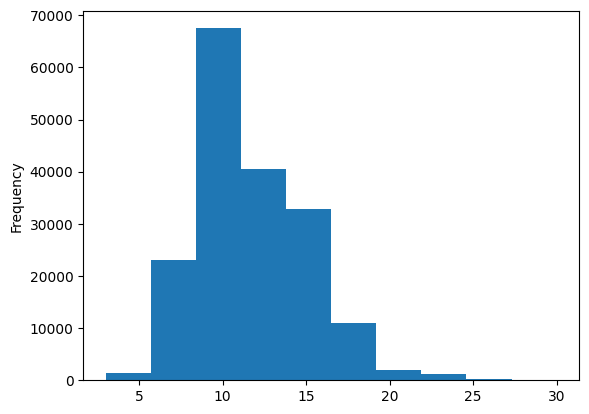

In [13]:
train_df.total_lines.plot.hist()

In [14]:
train_sentences = train_df.text.tolist()
test_sentences = test_df.text.tolist()
val_sentences = val_df.text.tolist()

len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

### Text to Numeric Preprocessing

In [15]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
# Label Encode Labels
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df.target.to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#### Creating Datasets

Going to setup the data to run as fast as possible using the TensorFlor tf.data API. The purpose of this is that TensorFlow has setup datasets that are used to optimize performance when training, validating, and testing by utilizing both the CPU and GPU as efficiently as they can be used.

To utilize this functionality, we must create datasets that can be used when experimenting with models.

#### Sentence Datasets

In [18]:
# Creating the final dataset to be used
train_slice_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_slice_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_slice_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_slice_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [19]:
# Take TensorSliceDataset and turn into prefetch models
train_dataset = train_slice_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_slice_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_slice_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Character Datasets

In [20]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [21]:
# Creating the final dataset to be used
train_chars_slice_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_chars_slice_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_chars_slice_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

train_chars_slice_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [22]:
# Take TensorSliceDataset and turn into prefetch models
train_char_dataset = train_chars_slice_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_chars_slice_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_chars_slice_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Experiments

The models I am building will all be compared against Model-0 (baseline) which does not use Deep Learning, rather it uses a Naive Bayes ML model.

0. Model-0 (Baseline): Naive Bayes w/ TF-IDF Encoder
1. Model-1: Conv1D w/ Token Embeddings
2. Model-2: TensorFlow Hub Pretrained Feature Extractor
3. Model-3: Conv1D w/ Character Embeddings
4. Model-4: Pretrained Token Embeddings (same as Model-2) + Character Embeddings (same as Model-3)
5. Model-5: Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

### Preprocessing Layer Setup

Many embedding layers will be reused for more than one of the experiments mentioned above. These steps will setup the layers to be used in experiments such that they can be reused for multiple models. The various layers to be made are:

* `text_vectorizer` (TextVectorizer)
* `token_embedding` (Embedding)
* `character_vectorizer` (TextVectorizer)
* `character_embeddings` (Embedding)
* `positional_embeddings`

#### Token Embeddings Layers

These layers consist of the `text_vectorizer` and the `embedding` layers that will be reused.

In [23]:
# Find average number of tokens
sent_lens = [len(i.split()) for i in train_sentences]
round(sum(sent_lens) / len(train_sentences))

26

In [24]:
# How long of a sentence covers 95% of the examples?
int(np.percentile(sent_lens, 95))

55

In [25]:
# Setup text vectorization params
max_vocab_length = 68000  # Max words to have in our vocab
max_length = 55  # Max length our sequence will be (95% of examples are within length of 55)

In [26]:
# Setting up a text vectorization layer (tokenization)
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_vocab_length,  # How many words in the vocabulary
    output_sequence_length=max_length)  # Padds (adds 0's to end of number) to make all the same length

# Adapt the vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [27]:
# Getting the words in the vocab from the training data
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
least_common_5_words = words_in_vocab[-5:]
len(words_in_vocab), top_5_words, least_common_5_words

(64841,
 ['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [28]:
# Config of text vectorizer layer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [29]:
# Setting up the Embedding layer
token_embedding = tf.keras.layers.Embedding(input_dim=len(words_in_vocab),
                                            output_dim=128,  # GPU's work well when number is divisible by 8
                                            mask_zero=True,
                                            name='token_embedding')
token_embedding

In [30]:
# Testing out an example sentence
target_sentence = random.choice(train_sentences)

# Looking at the steps of tokenization
print(f'Sentence before vectorization: \n {target_sentence}')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n {vectorized_sentence}')
embedded_sentence = token_embedding(vectorized_sentence)
print(f'Sentence after embedding: \n {embedded_sentence}')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
 the present study showed that superimposed e during cycling might be a useful tool to induce a high local stimulus to skeletal muscle even when performing low to moderate external workloads .
Sentence after vectorization: 
 [[    2   369    17   147    28 11830   949    52  2978   640    36     8
    998  1136     6  2822     8   181   585  3228     6  2681   368   983
    183  2045   220     6   362  1489 21322     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding: 
 [[[ 0.0189192   0.00551848 -0.04154292 ...  0.01862589  0.02786139
    0.02790321]
  [ 0.00418255  0.03834439  0.04293877 ...  0.02531022  0.04622345
   -0.00998306]
  [ 0.01828502 -0.01630352  0.02274365 ...  0.01833764  0.0304074
    0.02893071]
  ...
  [ 0.00793071  0.04790391 -0.02539178 ...  0.03880597 -0.04404117
    0.04860593]
  [ 0.00793071  0.04790391 -0.025391

#### Chracacter Embedding Layer

A character level embedding layer will require tokenizing characters before creating the embedding layer.

In [31]:
# Whats the avg character length?
chars_lens = [len(sentence) for sentence in train_sentences]
mean_chars_lens = np.mean(chars_lens)

mean_chars_lens

149.3662574983337

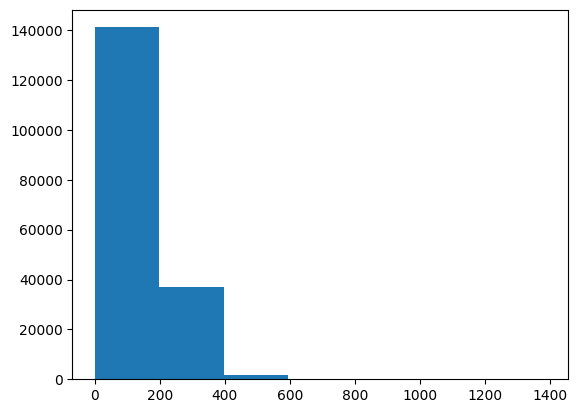

In [32]:
plt.hist(chars_lens, bins=7);

In [33]:
# Find character length for 95% of sentences
output_sequence_len = int(np.percentile(chars_lens, 95))
output_sequence_len

290

In [34]:
# Figuring out the total alpha-numeric characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
NUM_CHAR_TOKENS = len(alphabet) + 2  # Add 2 for space and OOV token ([UNK])
NUM_CHAR_TOKENS

70

In [36]:
character_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_sequence_len,
    name='char_vectorizer')

In [37]:
character_vectorizer.adapt(train_chars)

In [38]:
char_vocab = character_vectorizer.get_vocabulary()
print(f'Number of Different Characters: {len(char_vocab)}')
print(f'5 Most Common Characters: {char_vocab[:5]}')
print(f'5 Least Common Characters: {char_vocab[-5:]}')

Number of Different Characters: 28
5 Most Common Characters: ['', '[UNK]', 'e', 't', 'i']
5 Least Common Characters: ['k', 'x', 'z', 'q', 'j']


In [39]:
random_train_chars = random.choice(train_chars)

print(f'Text:\n{random_train_chars}')
print(f'Length: {len(random_train_chars.split())}')

vectorized_chars = character_vectorizer([random_train_chars])
print(f'Vectorized Chars:\n {vectorized_chars}')
print(f'Length of Vectorized Chars: {len(vectorized_chars[0])}')

Text:
i n   t h i s   r a n d o m i z e d   ,   d o u b l e - b l i n d   ,   p a r a l l e l - g r o u p   ,   s i n g l e - c e n t e r   ,   p r o o f - o f - p r i n c i p l e   c l i n i c a l   t r i a l   ,   w e   t e s t e d   t h e   h y p o t h e s i s   t h a t   @   s e s s i o n s   o f   a c t i v e   r t m s - d l p f c   d e l i v e r e d   o v e r   e i g h t   w e e k s   w o u l d   b e   f e a s i b l e   ,   s a f e   a n d   s u p e r i o r   t o   s h a m   r t m s   t o   d e c r e a s e   t h e   n u m b e r   o f   h e a d a c h e   d a y s   i n   @   p a t i e n t s   w i t h   c h r o n i c   m i g r a i n e   w i t h o u t   s e v e r e   d e p r e s s i o n   .
Length: 294
Vectorized Chars:
 [[ 4  6  3 13  4  9  8  5  6 10  7 15  4 25  2 10 10  7 16 22 12  2 22 12
   4  6 10 14  5  8  5 12 12  2 12 18  8  7 16 14  9  4  6 18 12  2 11  2
   6  3  2  8 14  8  7  7 17  7 17 14  8  4  6 11  4 14 12  2 11 12  4  6
   4 11  5 12  3  8  4  5 12 20  2  3  2  9  

In [40]:
character_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                                output_dim=25,
                                                mask_zero=True,
                                                name='character_embedding')
character_embedding

In [41]:
# Testing out an example sentence
target_chars = random.choice(train_chars)

# Looking at the steps of tokenization
print(f'Chars before vectorization: \n {target_chars}')

vectorized_chars = character_vectorizer([target_chars])
print(f'Chars after vectorization: \n {vectorized_chars}')
embedded_chars = character_embedding(vectorized_chars)
print(f'Chars after embedding: \n {embedded_chars}')
print(f'Embedded chars shape: {embedded_chars.shape}')

Chars before vectorization: 
 a l t   d i d   n o t   m a k e   t h e   l y m p h e d e m a   v o l u m e   w o r s e   a n d   t h e r e f o r e   m a y   s e r v e   a s   a   s a f e   a l t e r n a t i v e   t o   l a n d - b a s e d   t r e a t m e n t s   o f   b r e a s t   c a n c e r - r e l a t e d   l y m p h e d e m a   .
Chars after vectorization: 
 [[ 5 12  3 10  4 10  6  7  3 15  5 23  2  3 13  2 12 19 15 14 13  2 10  2
  15  5 21  7 12 16 15  2 20  7  8  9  2  5  6 10  3 13  2  8  2 17  7  8
   2 15  5 19  9  2  8 21  2  5  9  5  9  5 17  2  5 12  3  2  8  6  5  3
   4 21  2  3  7 12  5  6 10 22  5  9  2 10  3  8  2  5  3 15  2  6  3  9
   7 17 22  8  2  5  9  3 11  5  6 11  2  8  8  2 12  5  3  2 10 12 19 15
  14 13  2 10  2 15  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0

#### Positional Embedding Layer

A positional embedding layer will look at the position of each sentence within the abstract.

In [42]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

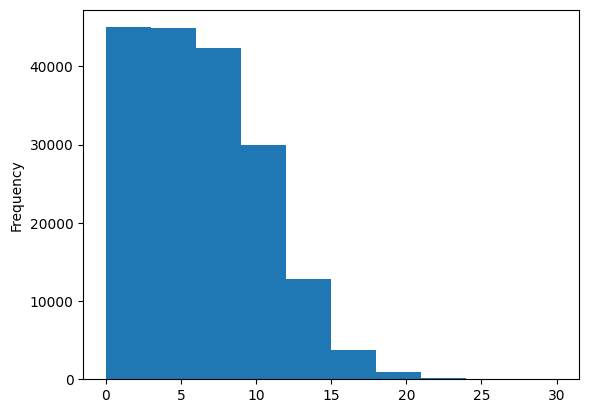

In [43]:
train_df['line_number'].plot.hist()

In [44]:
# See what number of lines covers 98% of the samples
max_lines = int(np.percentile(train_df['line_number'].to_numpy(), 98))
max_lines

15

In [45]:
# Encoding line_number tensors
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=max_lines)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=max_lines)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=max_lines)

train_line_numbers_one_hot[:15], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [46]:
train_line_number_sliced_dataset = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_labels_one_hot))
train_line_number_dataset = train_line_number_sliced_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_line_number_sliced_dataset = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_labels_one_hot))
val_line_number_dataset = val_line_number_sliced_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_line_number_sliced_dataset = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_labels_one_hot))
test_line_number_dataset = test_line_number_sliced_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_line_number_dataset, val_line_number_dataset, test_line_number_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [47]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

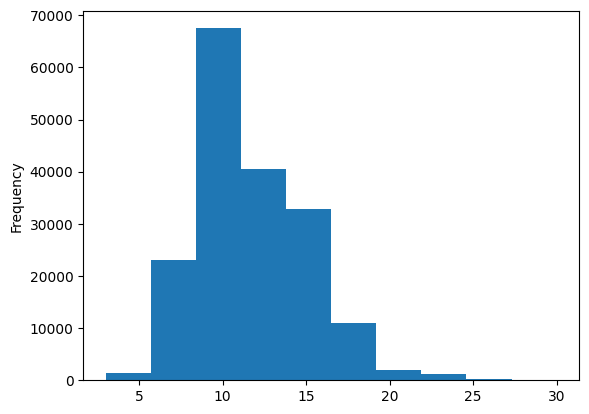

In [48]:
train_df['total_lines'].plot.hist()

In [49]:
max_total_lines = int(np.percentile(train_df['total_lines'], 98))
max_total_lines

20

In [50]:
# Encoding line_number tensors
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=max_total_lines)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=max_total_lines)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=max_total_lines)

train_total_lines_one_hot[:15], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [51]:
# Creating total lines datasets
train_total_lines_sliced_dataset = tf.data.Dataset.from_tensor_slices((train_total_lines_one_hot, train_labels_one_hot))
train_total_lines_dataset = train_total_lines_sliced_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_total_lines_sliced_dataset = tf.data.Dataset.from_tensor_slices((val_total_lines_one_hot, val_labels_one_hot))
val_total_lines_dataset = val_total_lines_sliced_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_total_lines_sliced_dataset = tf.data.Dataset.from_tensor_slices((test_total_lines_one_hot, test_labels_one_hot))
test_total_lines_dataset = test_total_lines_sliced_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_total_lines_dataset, val_total_lines_dataset, test_total_lines_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Model-0 (Baseline): Naive Bayes ML

As a baseline, I am going to look at the general machine learning algorithm, Multinomial Naive Bayes, which is commonly used for natural language processing classification.

In [124]:
# Constants
model_0_name = 'model_0_naive_bayes'

In [52]:
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

In [53]:
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [54]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [55]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [125]:
model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels_encoded,
                                                                                 model_0_preds,
                                                                                 name=model_0_name)
model_0_results

PredictionMetrics(accuracy=0.7218323844829869, precision=0.7186466952323352, recall=0.7218323844829869, f1=0.6989250353450294, name='model_0_naive_bayes')

### Model-1: Conv1D w/ Token Embeddings

In [122]:
# Constants
model_1_name = 'model_1_conv1d_token_embedding'

In [57]:
# Build Model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(token_embeddings)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.models.Model(inputs, outputs, name=model_1_name)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [58]:
# Compile Model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [59]:
# Fit Model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),  # Only going to look at 10% of data to speed up experimentation
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)),  # Only going to look at 10% of data to speed up experimentation
                              callbacks=[])

Epoch 1/3
562/562 [==============================] - 71s 124ms/step - loss: 0.8386 - accuracy: 0.6774 - val_loss: 0.5975 - val_accuracy: 0.7803
Epoch 2/3
562/562 [==============================] - 67s 120ms/step - loss: 0.5790 - accuracy: 0.7876 - val_loss: 0.5470 - val_accuracy: 0.7989
Epoch 3/3
562/562 [==============================] - 68s 121ms/step - loss: 0.5459 - accuracy: 0.7989 - val_loss: 0.5228 - val_accuracy: 0.8068


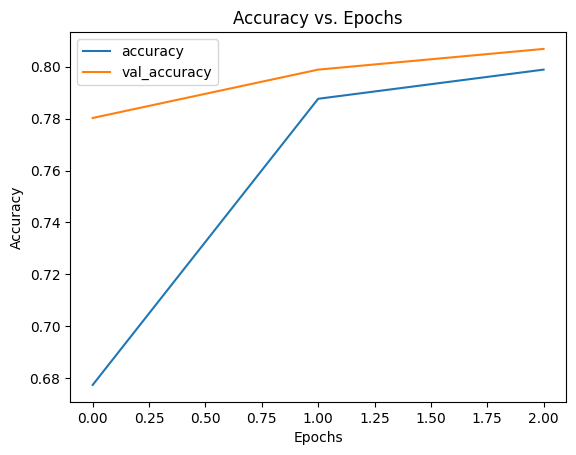

In [60]:
ml_toolbox.analysis.history.plot_history(model_1_history, 'accuracy')

In [61]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5258 - accuracy: 0.8042


[0.5258000493049622, 0.8042168617248535]

In [62]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[:10], model_1_pred_probs.shape

945/945 [==============================] - 6s 6ms/step


(array([[6.2268418e-01, 1.5449736e-01, 6.7459489e-03, 2.1121182e-01,
         4.8607942e-03],
        [2.8882504e-01, 6.2107348e-01, 1.0193484e-03, 8.6489357e-02,
         2.5927022e-03],
        [1.2087819e-01, 1.1656694e-02, 1.2859297e-03, 8.6600834e-01,
         1.7089304e-04],
        [1.1154987e-02, 1.3576765e-02, 9.0221250e-01, 7.5022751e-03,
         6.5553389e-02],
        [6.3338177e-03, 3.8599048e-02, 6.0590070e-01, 3.6225556e-03,
         3.4554389e-01],
        [6.9500471e-04, 1.5612603e-03, 4.5191520e-01, 5.6913990e-04,
         5.4525936e-01],
        [6.1140032e-05, 9.5602620e-04, 2.2445165e-01, 2.9855582e-05,
         7.7450132e-01],
        [2.1254329e-03, 5.1620719e-03, 7.1002799e-01, 2.7301591e-03,
         2.7995449e-01],
        [1.3675952e-05, 5.9549417e-04, 5.6068995e-03, 2.1940356e-05,
         9.9376190e-01],
        [3.1814083e-02, 7.6486915e-01, 5.0570630e-02, 1.6454456e-02,
         1.3629179e-01]], dtype=float32),
 (30212, 5))

In [63]:
# Get the max index
model_1_pred = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [123]:
model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels_encoded,
                                                                                 model_1_pred,
                                                                                 name=model_1_name)
model_1_results

PredictionMetrics(accuracy=0.8042168674698795, precision=0.8025652820142402, recall=0.8042168674698795, f1=0.8025946173805512, name='model_1_conv1d_token_embedding')

### Model-2: TensorFlow Hub Pretrained Feature Extractor

This model will use Transfer Learning with the `Universal Sentence Encoder` pretrained model on TensorFlow Hub (see link below). This model will not allow fine-tuning of the pretrained model.

* https://tfhub.dev/google/collections/universal-sentence-encoder/1

In [120]:
# Constants
model_2_name = 'model_2_pretrained_token'
universal_sentence_encoder_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

In [66]:
# Build Model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = hub.KerasLayer(universal_sentence_encoder_url,
                                      trainable=False,
                                      name='USE')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)
model_2.summary()

Model: "Model2USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [67]:
# Compile Model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [68]:
# Fit Model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),  # Only going to look at 10% of data to speed up experimentation
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)),  # Only going to look at 10% of data to speed up experimentation
                              callbacks=[])

Epoch 1/3
562/562 [==============================] - 14s 16ms/step - loss: 0.9154 - accuracy: 0.6521 - val_loss: 0.7955 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7665 - accuracy: 0.7025 - val_loss: 0.7517 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7470 - accuracy: 0.7136 - val_loss: 0.7338 - val_accuracy: 0.7188


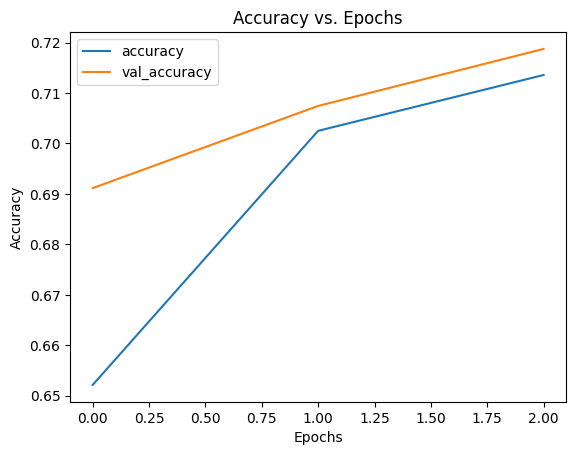

In [69]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'accuracy')

In [70]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.2635718e-01, 3.5907373e-01, 2.5475489e-03, 2.0308124e-01,
        8.9402515e-03],
       [3.5913673e-01, 4.9874806e-01, 4.0049548e-03, 1.3496469e-01,
        3.1456035e-03],
       [2.4939157e-01, 1.5275976e-01, 1.6403196e-02, 5.4529911e-01,
        3.6146417e-02],
       ...,
       [2.1594015e-03, 5.7163713e-03, 4.9588595e-02, 7.7551225e-04,
        9.4176012e-01],
       [4.2034849e-03, 4.7001638e-02, 1.8442719e-01, 1.7195287e-03,
        7.6264817e-01],
       [1.6606660e-01, 2.5943407e-01, 5.0253636e-01, 9.2535065e-03,
        6.2709369e-02]], dtype=float32)

In [71]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [121]:
model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels_encoded,
                                                                                 model_2_preds,
                                                                                 name=model_2_name)
model_2_results

PredictionMetrics(accuracy=0.7163709784191712, precision=0.7173741693140099, recall=0.7163709784191712, f1=0.7135175392077404, name='model_2_pretrained_token')

#### Findings

Looks like the predictions are significantly worse than both models.

### Model-3: Conv1D w/ Character Embeddings

Character embeddings creates an embedding for each character.

In [118]:
# Constants
model_3_name = 'model_3_conv1d_char_embedding'

In [73]:
# Build Model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

vectorized_chars = character_vectorizer(inputs)
embedded_chars = character_embedding(vectorized_chars)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(embedded_chars)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name='Model3CharEmbeddingConv1D')
model_3.summary()

Model: "Model3CharEmbeddingConv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 character_embedding (Embedd  (None, 290, 25)          700       
 ing)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                         

In [74]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [75]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),  # Only going to look at 10% of data to speed up experimentation
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)),  # Only going to look at 10% of data to speed up experimentation
                              callbacks=[])

Epoch 1/3
562/562 [==============================] - 16s 26ms/step - loss: 1.2684 - accuracy: 0.4906 - val_loss: 1.0309 - val_accuracy: 0.5908
Epoch 2/3
562/562 [==============================] - 14s 26ms/step - loss: 0.9940 - accuracy: 0.6005 - val_loss: 0.9265 - val_accuracy: 0.6270
Epoch 3/3
562/562 [==============================] - 14s 26ms/step - loss: 0.9238 - accuracy: 0.6367 - val_loss: 0.8648 - val_accuracy: 0.6559


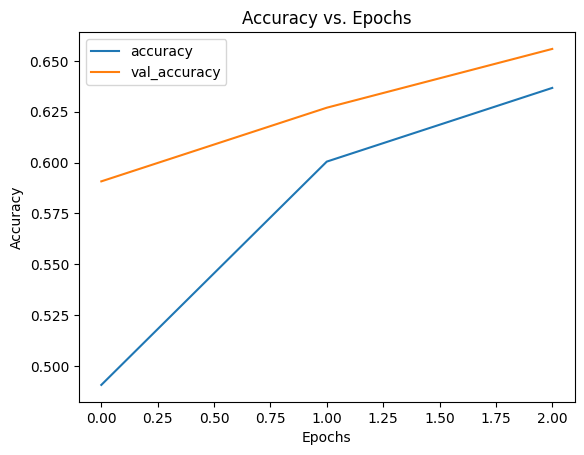

In [76]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'accuracy')

In [77]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 8s 8ms/step


array([[0.26369742, 0.40868974, 0.04238352, 0.25458947, 0.03063989],
       [0.22012971, 0.6864121 , 0.00427407, 0.06168432, 0.02749985],
       [0.15078266, 0.34734142, 0.24780422, 0.16936646, 0.08470528],
       ...,
       [0.02508515, 0.04513646, 0.12500645, 0.03191049, 0.77286154],
       [0.04655489, 0.18149275, 0.29441926, 0.03223864, 0.44529453],
       [0.3517508 , 0.43068936, 0.1349082 , 0.06638506, 0.01626668]],
      dtype=float32)

In [78]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [119]:
model_3_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels_encoded,
                                                                                 model_3_preds,
                                                                                 name=model_3_name)
model_3_results

PredictionMetrics(accuracy=0.6574539917913412, precision=0.651457316473861, recall=0.6574539917913412, f1=0.6458660887393802, name='model_3_conv1d_char_embedding')

### Model-4: Pretrained Token Embeddings (same as Model-2) + Character Embeddings (same as Model-3)

Combining both a pretrained token embedding model with the character embedding model will concatenate the outcomes of the two models before running it through the output layer.

1. Create a token level embedding model (similar to Model-2)
2. Create a character level embedding model (similar to Model-3 with a slight modification)
3. Combine the two models using a concatenate layer
4. Build output layers on top of step 3 similar to the model built in the paper.

In [116]:
# Constants
model_4_name='model_4_pretrained_token_char'
universal_sentence_encoder_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

In [81]:
# Creating the specific datasets for the concatenated data
train_token_character_dataset = data_toolbox.generate_dataset_from_data([train_sentences, train_chars], train_labels_one_hot)
val_token_character_dataset = data_toolbox.generate_dataset_from_data([val_sentences, val_chars], val_labels_one_hot)
test_token_character_dataset = data_toolbox.generate_dataset_from_data([test_sentences, test_chars], test_labels_one_hot)

train_token_character_dataset, val_token_character_dataset, test_token_character_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [82]:
# Build Model

# 1. Build Pretrained Token Embeddings Model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')

pretrained_token_embedding = hub.KerasLayer(universal_sentence_encoder_url,
                                            trainable=False,
                                            name='universal_sentence_encoder')(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(pretrained_token_embedding)

token_embedding_model = tf.keras.models.Model(token_inputs, token_outputs)

# 2. Build Character Embeddings Model (This is similar to the model in the paper, it uses Bi-LSTM as the Output Layer)
character_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')

char_vectors = character_vectorizer(character_inputs)
char_embeddings = character_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)

character_embedding_model = tf.keras.models.Model(character_inputs, char_bi_lstm)

# 3. Concatenating the two models
token_char_concat = tf.keras.layers.Concatenate(name='token_char_hybrid')([token_embedding_model.output, character_embedding_model.output])

# 4. Creating output layers (with dropout as done in the paper)
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Creating the Model
model_4 = tf.keras.models.Model(inputs=[token_embedding_model.input, character_embedding_model.input],
                                outputs=outputs,
                                name=model_4_name)
model_4.summary()

Model: "model_4_token_character_hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['to

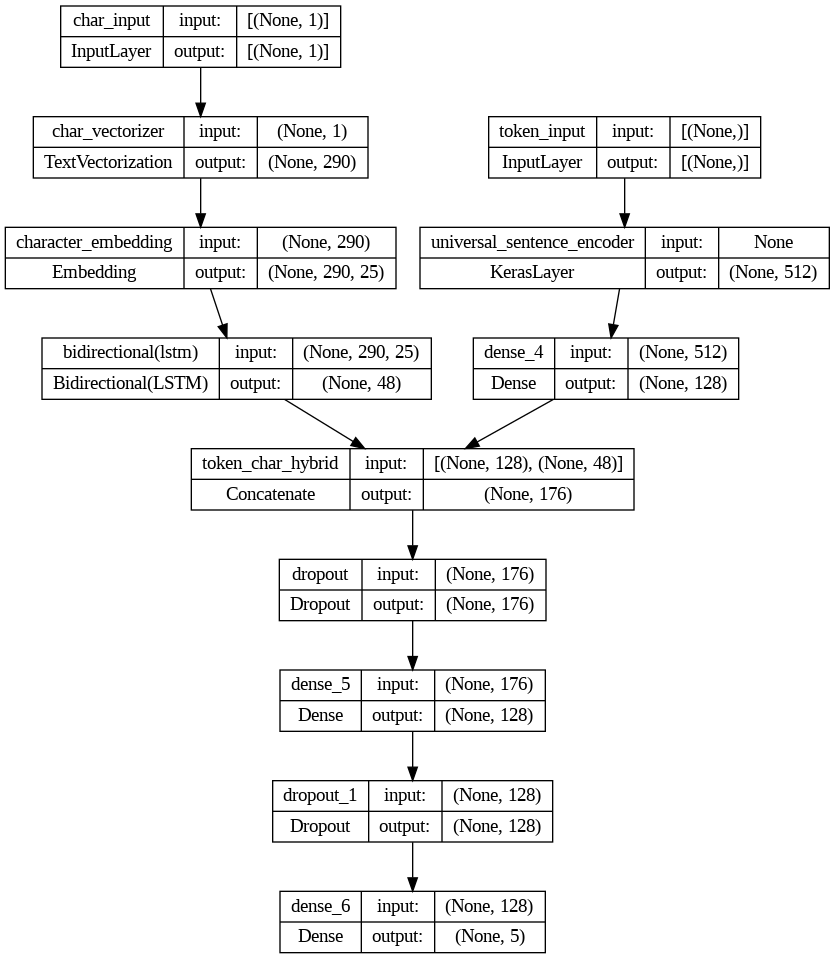

In [83]:
ml_toolbox.analysis.model.plot_model(model_4)

In [84]:
# Compile model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [85]:
# Fit Model
model_4_history = model_4.fit(train_token_character_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_token_character_dataset)),
                              validation_data=val_token_character_dataset,
                              validation_steps=int(0.1 * len(val_token_character_dataset)))

Epoch 1/3
562/562 [==============================] - 256s 434ms/step - loss: 0.9861 - accuracy: 0.6060 - val_loss: 0.7936 - val_accuracy: 0.6991
Epoch 2/3
562/562 [==============================] - 222s 396ms/step - loss: 0.7983 - accuracy: 0.6949 - val_loss: 0.7192 - val_accuracy: 0.7247
Epoch 3/3
562/562 [==============================] - 206s 366ms/step - loss: 0.7736 - accuracy: 0.7038 - val_loss: 0.6916 - val_accuracy: 0.7304


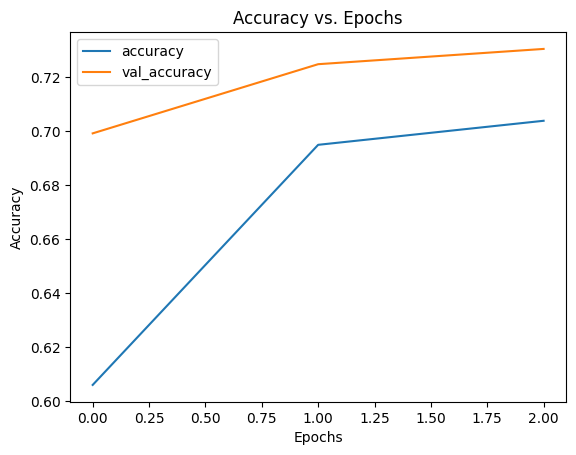

In [86]:
ml_toolbox.analysis.history.plot_history(model_4_history, 'accuracy')

In [87]:
model_4_pred_probs = model_4.predict(val_token_character_dataset)
model_4_pred_probs

945/945 [==============================] - 76s 77ms/step


array([[4.39372182e-01, 3.41113806e-01, 8.56203213e-03, 1.99853405e-01,
        1.10985795e-02],
       [3.78122479e-01, 4.84096259e-01, 3.80938430e-03, 1.30913064e-01,
        3.05894925e-03],
       [3.17617476e-01, 1.21571481e-01, 8.38870108e-02, 4.40148443e-01,
        3.67756747e-02],
       ...,
       [6.47751265e-04, 9.67836101e-03, 6.79608956e-02, 3.07324168e-04,
        9.21405673e-01],
       [6.01761695e-03, 6.79397658e-02, 2.19210610e-01, 3.21134878e-03,
        7.03620672e-01],
       [2.59539515e-01, 4.54843163e-01, 1.84914216e-01, 3.51287872e-02,
        6.55743331e-02]], dtype=float32)

In [88]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [117]:
model_4_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels_encoded,
                                                                                 model_4_preds,
                                                                                 name=model_4_name)
model_4_results

PredictionMetrics(accuracy=0.7338474778233814, precision=0.7335235063367156, recall=0.7338474778233814, f1=0.7306996767185419, name='model_4_pretrained_token_char')

### Model-5: Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

This model will take into account the various embedding types used thus far, and add an additional embedding dataset that looks at the positional embeddings (location of each line within the abstract).

To build this model, we will be performing the following steps:

1. Create a token level model
2. Create a character level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Concatenate the outputs of token level model and character level model.
6. Concatenate the outputs of `line_number` feature model, `total_lines` feature model, and the concatenated model from step 5.
7. Create an output layer that accepts the output of the concatenated tribrid embedding model in step 6, and outputs the label probabilities.
8. Create the fully combined model from all the steps.

**NOTE**: Any engineered features used to train the model need to be available at test time. In our case, line numbers and total line numbers in an abstract are available.



In [111]:
# Constants
model_5_name = 'model_5_token_char_positional'
universal_sentence_encoder_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

In [90]:
# Creating the dataset for working in model 5
# NOTE: Order of the datasets matters! It must match the order of the concatenation in the model
train_token_character_position_dataset = data_toolbox.generate_dataset_from_data([train_line_numbers_one_hot,
                                                                                  train_total_lines_one_hot,
                                                                                  train_sentences,
                                                                                  train_chars], train_labels_one_hot)

val_token_character_position_dataset = data_toolbox.generate_dataset_from_data([val_line_numbers_one_hot,
                                                                                val_total_lines_one_hot,
                                                                                val_sentences,
                                                                                val_chars], val_labels_one_hot)

test_token_character_position_dataset = data_toolbox.generate_dataset_from_data([test_line_numbers_one_hot,
                                                                                 test_total_lines_one_hot,
                                                                                 test_sentences,
                                                                                 test_chars], test_labels_one_hot)

train_token_character_position_dataset, val_token_character_position_dataset, test_token_character_position_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [92]:
# 1. Token Embedding Model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')
pretrained_token_embedding = hub.KerasLayer(universal_sentence_encoder_url,
                                            trainable=False,
                                            name='universal_sentence_encoder')(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(pretrained_token_embedding)

token_embedding_model = tf.keras.models.Model(token_inputs, token_outputs, name='token_embedding')

# 2. Character Embedding Model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = character_vectorizer(char_inputs)
char_embeddings = character_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)

character_embedding_model = tf.keras.models.Model(char_inputs, char_bi_lstm, name='character_embedding')

# 3. Line Number Feature Model
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_number_outputs = tf.keras.layers.Dense(32, activation='relu')(line_number_inputs)

line_number_feature_model = tf.keras.models.Model(line_number_inputs, line_number_outputs, name='line_number_feature')

# 4. Total Lines Feature Model
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = tf.keras.layers.Dense(32, activation='relu')(total_lines_inputs)

total_lines_feature_model = tf.keras.models.Model(total_lines_inputs, total_lines_outputs, name='total_lines_feature')

# 5. Concatenate Token and Character Level Models (including dropout layer)
token_char_concat = tf.keras.layers.Concatenate(name='token_char_hybrid_embedding')([token_embedding_model.output, character_embedding_model.output])
x = tf.keras.layers.Dense(256, activation='relu')(token_char_concat)
combined_token_char_embeddings_dropout = tf.keras.layers.Dropout(0.5)(x)

# 6. Concatenate Line Number Feature Model, Total Lines Feature Model, and Token Char Concatenated Hybrid
tribrid_concat = tf.keras.layers.Concatenate(name='token_char_positional_embedding')([line_number_feature_model.output,
                                                                                      total_lines_feature_model.output,
                                                                                      combined_token_char_embeddings_dropout])

# 7. Output Layers
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_concat)

# 8. Create Model
model_5 = tf.keras.models.Model(inputs=[line_number_feature_model.input,
                                        total_lines_feature_model.input,
                                        token_embedding_model.input,
                                        character_embedding_model.input],
                                outputs=output_layer,
                                name=model_5_name)
model_5.summary()

Model: "model_5_token_char_positional"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['tok

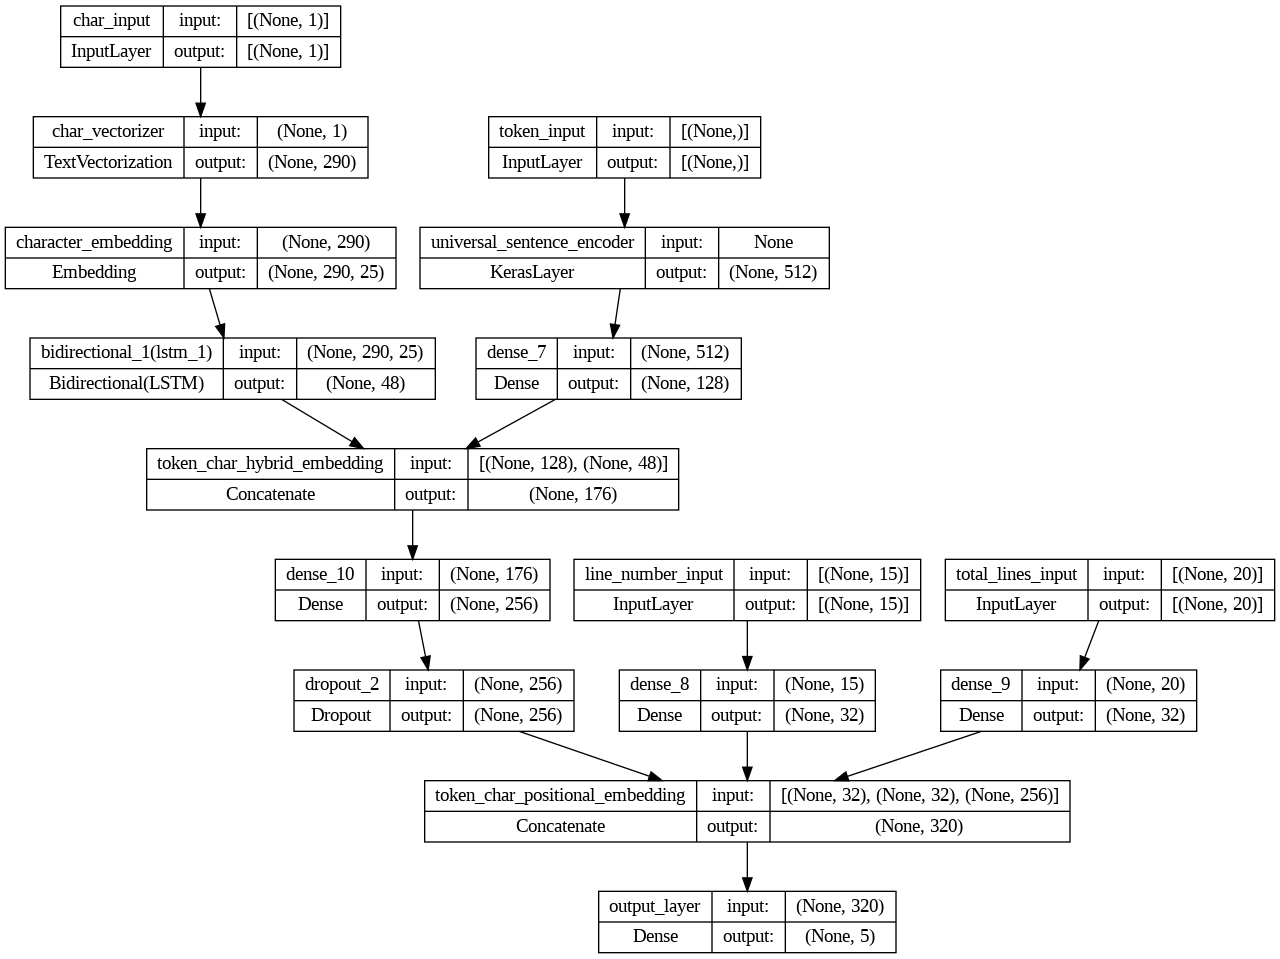

In [93]:
ml_toolbox.analysis.model.plot_model(model_5)

In [94]:
# Compile Model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),  # label_smoothing helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [95]:
model_5_history = model_5.fit(train_token_character_position_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_token_character_position_dataset)),
                              validation_data=val_token_character_position_dataset,
                              validation_steps=int(0.1 * len(val_token_character_position_dataset)))

Epoch 1/3
562/562 [==============================] - 217s 364ms/step - loss: 1.0922 - accuracy: 0.7272 - val_loss: 0.9821 - val_accuracy: 0.8022
Epoch 2/3
562/562 [==============================] - 201s 357ms/step - loss: 0.9667 - accuracy: 0.8153 - val_loss: 0.9480 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 200s 355ms/step - loss: 0.9503 - accuracy: 0.8235 - val_loss: 0.9351 - val_accuracy: 0.8334


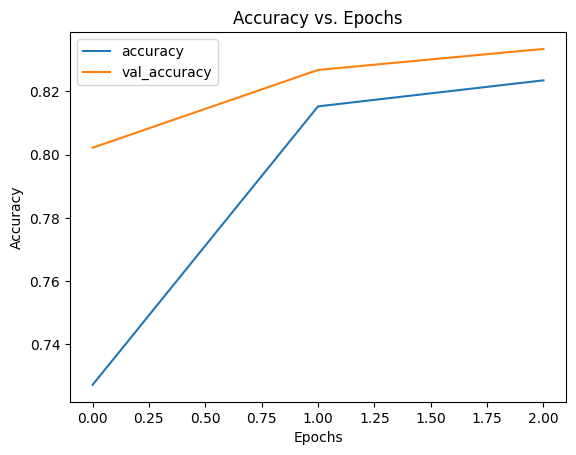

In [96]:
ml_toolbox.analysis.history.plot_history(model_5_history, 'accuracy')

In [97]:
model_5_pred_probs = model_5.predict(val_token_character_position_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 75s 75ms/step


array([[0.4739824 , 0.11603823, 0.01389534, 0.37173   , 0.02435397],
       [0.5214471 , 0.09805597, 0.05974365, 0.30894735, 0.01180588],
       [0.29380465, 0.10373195, 0.13579752, 0.3917598 , 0.07490606],
       ...,
       [0.03661503, 0.11396361, 0.04613828, 0.03295601, 0.7703271 ],
       [0.02677041, 0.33052608, 0.06815957, 0.02472098, 0.54982305],
       [0.15685011, 0.65082043, 0.08763855, 0.0398846 , 0.0648063 ]],
      dtype=float32)

In [98]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [112]:
model_5_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels_encoded,
                                                                                 model_5_preds,
                                                                                 name=model_5_name)
model_5_results

PredictionMetrics(accuracy=0.835032437442076, precision=0.833661381112976, recall=0.835032437442076, f1=0.8340397194172973, name='model_5_token_char_positional')

## Analysis

Now that the 5 different experiments have been run, it is time to compare and analyze them.

#### Prediction Metric Analysis

In [126]:
all_results = [model_0_results, model_1_results, model_2_results, model_3_results, model_4_results, model_5_results]
all_results

[PredictionMetrics(accuracy=0.7218323844829869, precision=0.7186466952323352, recall=0.7218323844829869, f1=0.6989250353450294, name='model_0_naive_bayes'),
 PredictionMetrics(accuracy=0.8042168674698795, precision=0.8025652820142402, recall=0.8042168674698795, f1=0.8025946173805512, name='model_1_conv1d_token_embedding'),
 PredictionMetrics(accuracy=0.7163709784191712, precision=0.7173741693140099, recall=0.7163709784191712, f1=0.7135175392077404, name='model_2_pretrained_token'),
 PredictionMetrics(accuracy=0.6574539917913412, precision=0.651457316473861, recall=0.6574539917913412, f1=0.6458660887393802, name='model_3_conv1d_char_embedding'),
 PredictionMetrics(accuracy=0.7338474778233814, precision=0.7335235063367156, recall=0.7338474778233814, f1=0.7306996767185419, name='model_4_pretrained_token_char'),
 PredictionMetrics(accuracy=0.835032437442076, precision=0.833661381112976, recall=0.835032437442076, f1=0.8340397194172973, name='model_5_token_char_positional')]

In [127]:
all_results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
all_results_df

,accuracy,precision,recall,f1,name
model_0_naive_bayes,0.721832,0.718647,0.721832,0.698925,model_0_naive_bayes
model_1_conv1d_token_embedding,0.804217,0.802565,0.804217,0.802595,model_1_conv1d_token_embedding
model_2_pretrained_token,0.716371,0.717374,0.716371,0.713518,model_2_pretrained_token
model_3_conv1d_char_embedding,0.657454,0.651457,0.657454,0.645866,model_3_conv1d_char_embedding
model_4_pretrained_token_char,0.733847,0.733524,0.733847,0.7307,model_4_pretrained_token_char
model_5_token_char_positional,0.835032,0.833661,0.835032,0.83404,model_5_token_char_positional


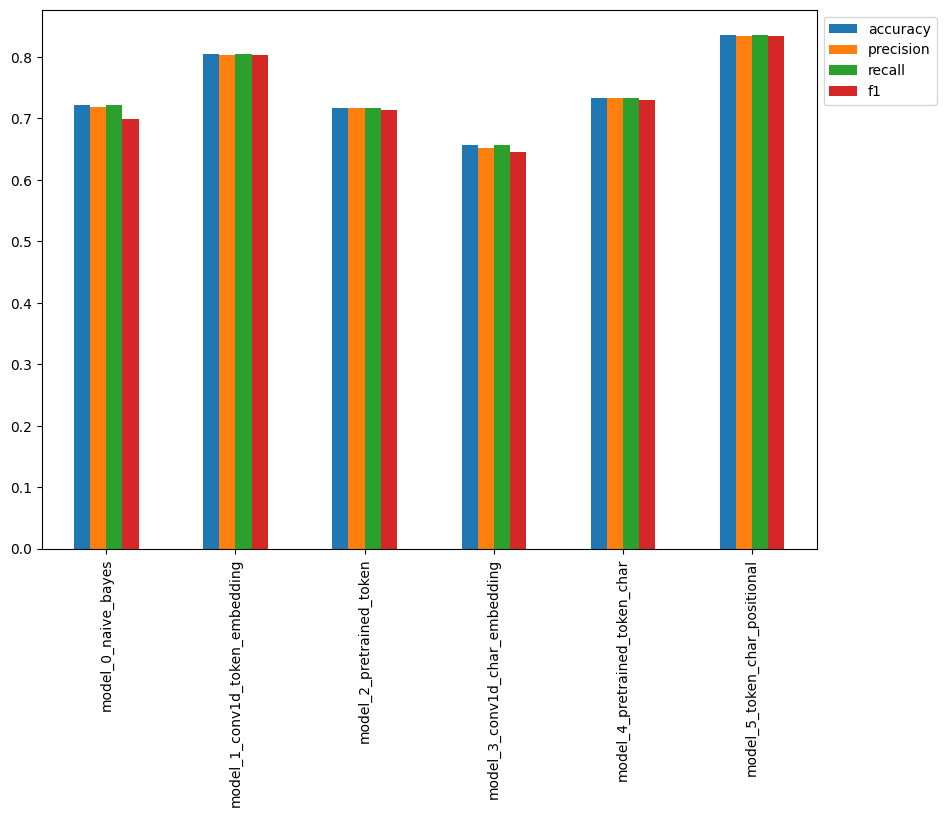

In [128]:
all_results_df.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

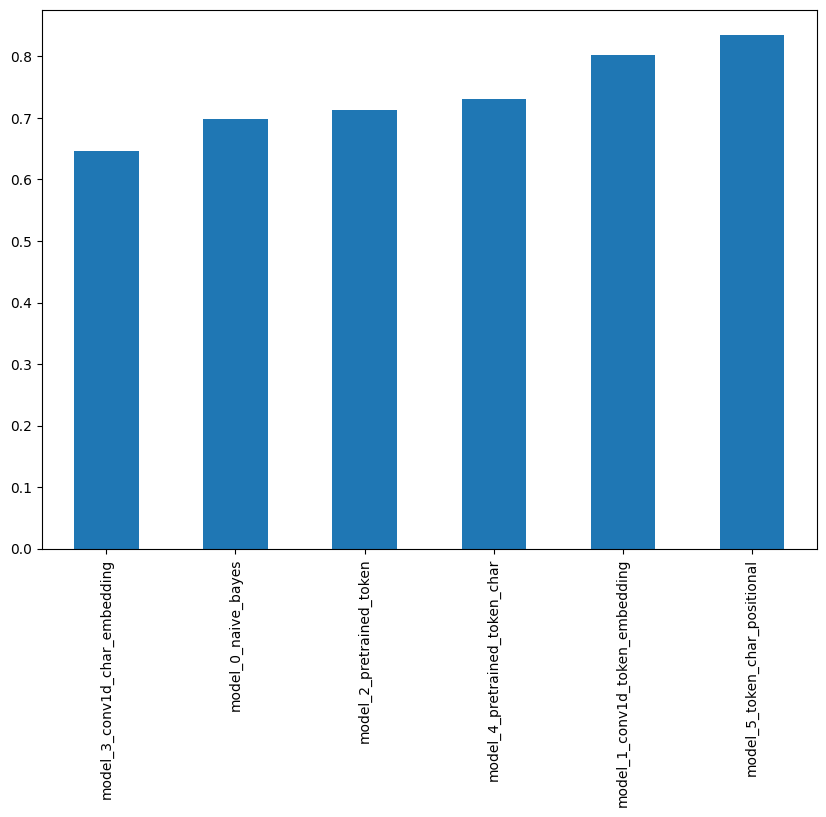

In [129]:
all_results_df.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10, 7))

#### Performance Metrics Analysis

In [130]:
# Generating the model performance metrics
model_performances = [
    performance_toolbox.model.time_predictions(model_0, val_sentences, name=model_0_results.name),
    performance_toolbox.model.time_predictions(model_1, val_dataset, name=model_1_results.name),
    performance_toolbox.model.time_predictions(model_2, val_dataset, name=model_2_results.name),
    performance_toolbox.model.time_predictions(model_3, val_char_dataset, name=model_3_results.name),
    performance_toolbox.model.time_predictions(model_4, val_token_character_dataset, name=model_4_results.name),
    performance_toolbox.model.time_predictions(model_5, val_token_character_position_dataset, name=model_5_results.name),
]

model_performances

945/945 [==============================] - 74s 78ms/step


[Performance(total_time=1.0523159700001088, total_predictions=30212, name='model_0_naive_bayes'),
 Performance(total_time=5.372787759999937, total_predictions=945, name='model_1_conv1d_token_embedding'),
 Performance(total_time=14.369519116999982, total_predictions=945, name='model_2_pretrained_token'),
 Performance(total_time=10.230488100999992, total_predictions=945, name='model_3_conv1d_char_embedding'),
 Performance(total_time=81.91758854199998, total_predictions=945, name='model_4_pretrained_token_char'),
 Performance(total_time=81.91982706599993, total_predictions=945, name='model_5_token_char_positional')]

In [131]:
performance_results_df = performance_toolbox.model.generate_performance_dataframe(model_performances)
performance_results_df

,total_time,total_predictions,time_per_prediction
model_0_naive_bayes,1.052316,30212.0,0.000035
model_1_conv1d_token_embedding,5.372788,945.0,0.005685
model_2_pretrained_token,14.369519,945.0,0.015206
model_3_conv1d_char_embedding,10.230488,945.0,0.010826
model_4_pretrained_token_char,81.917589,945.0,0.086685
model_5_token_char_positional,81.919827,945.0,0.086688


<Axes: >

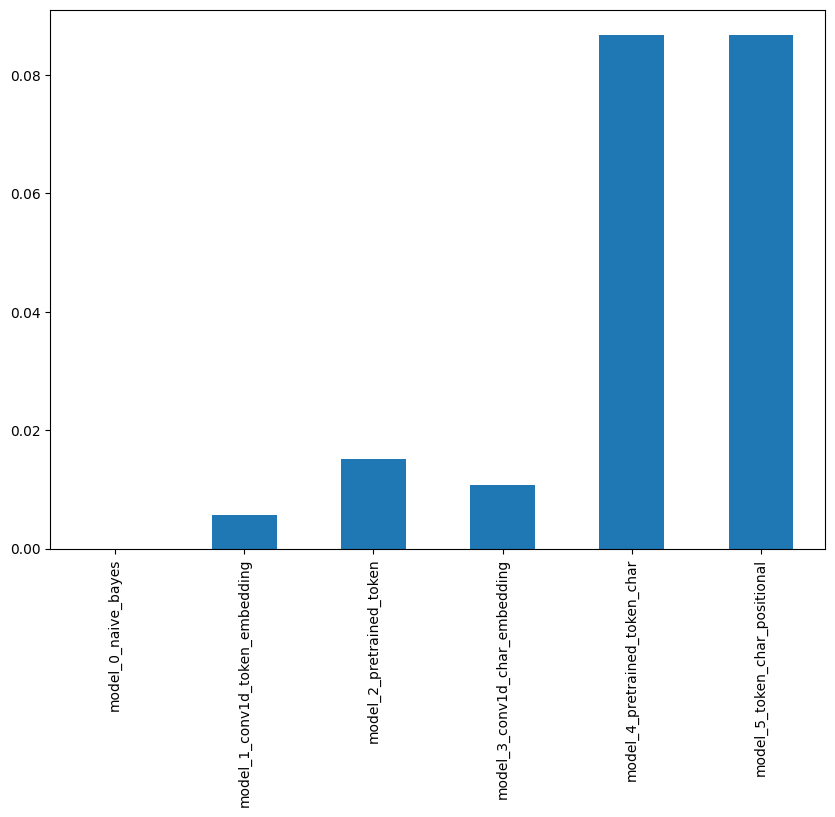

In [132]:
performance_results_df['time_per_prediction'].plot(kind='bar', figsize=(10, 7))

#### Findings
After evaluating the model metrics, it looks like model_5 outperformed all other models in terms of prediction metrics. In terms of performance metrics, model_5 was significantly less performant than model_1 and the baseline (model_0).

## Exporting Model

Now that I have identified the top performing model, I want to export it from google colab for reuse.

In [ ]:
model_5_filepath = './models/skimlit_tribrid_model'

In [ ]:
model_5.save(model_5_filepath)

In [ ]:
# Verifying export works as expected
loaded_model = tf.keras.models.load_model(model_5_filepath)

In [ ]:
# Verifying model_5 and loaded_model are equivalent
loaded_pred_probs = loaded_model.predict(val_token_character_position_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_model_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels_encoded, loaded_preds)

945/945 [==============================] - 23s 21ms/step


In [ ]:
loaded_model_results, model_5_results

(PredictionMetrics(accuracy=0.8336422613531047, precision=0.8332316379428193, recall=0.8336422613531047, f1=0.8324579099972697),
 PredictionMetrics(accuracy=0.8336422613531047, precision=0.8332316379428193, recall=0.8336422613531047, f1=0.8324579099972697))

#### Findings

After saving the model, then loading it back in and comparing against the original model, the performance is exactly the same. This confirms the export worked as expected.